In [6]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types

sc = pyspark.SparkContext(appName="phishingURL-AUTOML-BestModel-Discovery")
sqlContext = SQLContext(sc)

import h2o
from h2o.automl import H2OAutoML

import subprocess
subprocess.run('unset http_proxy', shell=True)

h2o.init(ip="localhost",port=54321)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_172"; Java(TM) SE Runtime Environment (build 1.8.0_172-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.172-b11, mixed mode)
  Starting server from /opt/cloudera/parcels/Anaconda-5.1.0.1/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9g7k3wxz
  JVM stdout: /tmp/tmp9g7k3wxz/h2o_siemanalyst_started_from_python.out
  JVM stderr: /tmp/tmp9g7k3wxz/h2o_siemanalyst_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_siemanalyst_sc9rzz
H2O cluster total nodes:,1
H2O cluster free memory:,5.176 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


In [5]:
sc.stop()

In [35]:
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy import stats

## URL KL from URL TO English Language function6.
def func_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
    
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:6]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch."
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
func_kl_en_url_udf = udf(func_kl_en_url, FloatType())

result=func_kl_en_url("https://10.12.61.1/bug")
print(result)
# -330.2231122802843

result=func_kl_en_url("https://www.google.com")
print(result)
# 0.0

## URL count(".com") function7.
def func_count_dot_com(var1):
    return var1.count(".com") #overlapping
func_count_dot_com_udf = udf(func_count_dot_com, IntegerType())
#print(func_count_dot_com("http://www.sapo.pt.com.test.com"))

## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_en_url(var1):
    
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:6]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch."
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
    
func_ks_en_url_udf = udf(func_ks_en_url, FloatType())

print(func_ks_en_url("http://www.google.com"))
#www.go
#[ 46  46  99 101 103 103 108 109 111 111 111 119 119 119]
#[ 46  46  97  99 100 101 102 109 110 111 111 112 114 122]
# 1.0

print(func_ks_en_url("https://10.12.61.1/bug"))
# 0.0029651946233535


-330.2231122802843
0.0
1.0
0.0029651946233535


In [36]:
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest


## ynverified=1/0 as phishing
## To be discovered with ML/DL/CNN
def func_url_verified(var1):
    if ( var1.lower()=='yes'):
        return 1
    elif (var1.lower()=='no'):
        return 0
    else :
        return 1
func_url_verified_udf = udf(func_url_verified, IntegerType())    

## URL size function1.
def func_url_lengh(var1):
    return len(var1)
func_url_lengh_udf = udf(func_url_lengh, IntegerType())

### Every URL with More than 80 chars, will be massive .
## URL isbig=1/0 function2.
def func_url_big(var1):
    if (len(var1) > 80):
        return 1
    else: 
        return 0
func_url_big_udf = udf(func_url_big, IntegerType())

## URL number of '@' chars function3.
def func_url_count_at(var1):
    return var1.count('@')
func_url_count_at_udf = udf(func_url_count_at, IntegerType())

## URL punctuation count function4.
def func_url_count_dot(var1):
    return var1.count('.')
func_url_count_dot_udf = udf(func_url_count_dot, IntegerType())

## URL isipyn=1/0 function5.
## Search if matches pattern : "http://xx.xx.xx.xx/anythingnonspace7662u.wkjw3932"
def func_url_is_ip(var1):
    cleanvar=var1.strip('http://').strip('https://')
    m = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)([\S]+)',cleanvar)
    if m:
        return 1
    else:
        return 0
func_url_is_ip_udf = udf(func_url_is_ip, IntegerType())

## URL KL from URL TO English Language function6.
def func_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
    
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:6]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch."
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
func_kl_en_url_udf = udf(func_kl_en_url, FloatType())

## URL count(".com") function7.
def func_count_dot_com(var1):
    return var1.count(".com") #overlapping
func_count_dot_com_udf = udf(func_count_dot_com, IntegerType())

## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_en_url(var1):
    
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:6]
    
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.\
    www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.\
    andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd\
    HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com\
    www.1.2.3.4.5.6.7.8.9.0.\
    .llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch."
    
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue) ##BUG https://issues.apache.org/jira/browse/SPARK-12157
    ## Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
func_ks_en_url_udf = udf(func_ks_en_url, FloatType())


## Get all URL Commom Crawl from
## List of Top Level Domains : *.com *.org *.co.uk *.ru *.net *.cn *.cz *.kp *.us "
# 
ccrawl_traindf = sqlContext.read.json("hdfs:///user/siemanalyst/data/raw/commoncrawl/dt=20181112/clean-CC-MAIN-2018-43-index-.*.json")

## Assume URLS as not phishing ynverified=0
ccrawl_trainds = ccrawl_traindf.withColumn('ynverified',lit(0))\
.withColumn('url_length',func_url_lengh_udf(ccrawl_traindf['url']))\
.withColumn('massiveurl',func_url_big_udf(ccrawl_traindf['url']))\
.withColumn('count_at',func_url_count_at_udf(ccrawl_traindf['url']))\
.withColumn('count_dot',func_url_count_dot_udf(ccrawl_traindf['url']))\
.withColumn('url_is_ip',func_url_is_ip_udf(ccrawl_traindf['url']))\
.withColumn('url_kl_en',func_kl_en_url_udf(ccrawl_traindf['url']).cast('double'))\
.withColumn('count_dot_com',func_count_dot_com_udf(ccrawl_traindf['url']))\
.withColumn('url_ks_en',func_ks_en_url_udf(ccrawl_traindf['url']).cast('double'))\
.drop('charset','digest','filename','verification_time','languages','length','mime','mime-detected','offset','status')
#

ccrawl_trainds.printSchema()
ccrawl_persist=ccrawl_trainds.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)

### From Phishtank Import Malware urls
#phishtank_trainpd=pd.read_csv("/home/siemanalyst/notebooks/siem/verified_online.csv")
#phishtank_trainds=phishtank_trainpd.drop(columns=['phish_id','phish_detail_url','submission_time','verification_time','online','target'])
#phishtank_trainds['url_length'] = phishtank_trainds['url'].map(str).apply(len)
#phishtank_trainds['massiveurl'] = np.where(phishtank_trainds['url_length'] > 80 , 1, 0)
#phishtank_trainds.head(6)
#phishtank_train=h2o.H2OFrame(phishtank_trainds)
#
#phishtank_testpd=pd.read_csv("/home/siemanalyst/notebooks/siem/verified_online.csv")
#phishtank_testds=phishtank_testpd.drop(columns=['phish_id','phish_detail_url','submission_time','verification_time','online','target'])
#phishtank_testds['url_length'] = phishtank_testds['url'].map(str).apply(len)
#phishtank_testds['massiveurl'] = np.where(phishtank_testds['url_length'] > 80 , 1, 0)
#phishtank_testds.head(6)
#phishtank_test=h2o.H2OFrame(phishtank_testds.head(1000))
#
phishtank_traindf= sqlContext.read.json("hdfs:///user/siemanalyst/data/raw/phishtank/dt=20181112/verified_online.json")
phishtank_traindf.printSchema()

phishtank_trainds=phishtank_traindf\
.withColumn('ynverified',func_url_verified_udf(phishtank_traindf['verified']))\
.withColumn('url_length',func_url_lengh_udf(phishtank_traindf['url']))\
.withColumn('massiveurl',func_url_big_udf(phishtank_traindf['url']))\
.withColumn('count_at',func_url_count_at_udf(phishtank_traindf['url']))\
.withColumn('count_dot',func_url_count_dot_udf(phishtank_traindf['url']))\
.withColumn('url_is_ip',func_url_is_ip_udf(phishtank_traindf['url']))\
.withColumn('url_kl_en',func_kl_en_url_udf(phishtank_traindf['url']).cast('double'))\
.withColumn('count_dot_com',func_count_dot_com_udf(phishtank_traindf['url']))\
.withColumn('url_ks_en',func_ks_en_url_udf(phishtank_traindf['url']).cast('double'))\
.drop('details','online','phish_detail_url','phish_id','submission_time','target','verification_time','verified')
#
    
phishtank_trainds.printSchema()
phishtank_persist=phishtank_trainds.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)

ccrawl_train_pd=ccrawl_persist.toPandas()  
ccrawl_test_pd=ccrawl_persist.toPandas().head(8000)
ccrawl_train_hf=h2o.H2OFrame(ccrawl_train_pd)
ccrawl_test_hf=h2o.H2OFrame(ccrawl_test_pd)

# H2OContext not possible to complex to serialize
#ccrawl_train_hf = hc.as_h2o_frame(ccrawl_persist)
#ccrawl_test_hf= hc.as_h2o_frame(ccrawl_persist.head(8000))

phishtank_train_pd=phishtank_persist.toPandas()  
phishtank_test_pd=phishtank_persist.toPandas().head(8000)
phishtank_train=h2o.H2OFrame(phishtank_train_pd)
phishtank_test=h2o.H2OFrame(phishtank_test_pd)


# RBIND "Merge" all of df2 into df1 with rbind .
# function merge() doesn't work if both H2O/dataframes have same variables


###### TRAINING PROCESS ############
#
train = ccrawl_train_hf.rbind(phishtank_train)
test = ccrawl_test_hf.rbind(phishtank_test)

# Identify predictors and response
x = train.columns

# test Learning is it a bit URL TRUE/FALSE
#y = 'massiveurl'

# Casual is it verified phishing from url characteristics TRUE/FALSE
y= 'ynverified'
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 40 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=40, seed=1999)
aml.train(x=x, y=y, training_frame=train)


root
 |-- url: string (nullable = true)
 |-- ynverified: integer (nullable = false)
 |-- url_length: integer (nullable = true)
 |-- massiveurl: integer (nullable = true)
 |-- count_at: integer (nullable = true)
 |-- count_dot: integer (nullable = true)
 |-- url_is_ip: integer (nullable = true)
 |-- url_kl_en: double (nullable = true)
 |-- count_dot_com: integer (nullable = true)
 |-- url_ks_en: double (nullable = true)

root
 |-- details: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- announcing_network: string (nullable = true)
 |    |    |-- cidr_block: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- detail_time: string (nullable = true)
 |    |    |-- ip_address: string (nullable = true)
 |    |    |-- rir: string (nullable = true)
 |-- online: string (nullable = true)
 |-- phish_detail_url: string (nullable = true)
 |-- phish_id: string (nullable = true)
 |-- submission_time: string (nullable = true)
 

In [37]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20181114_141050,0.961158,0.176769,0.120502,0.22048,0.0486116
DRF_1_AutoML_20181114_141050,0.96004,0.171377,0.125346,0.21974,0.0482857
StackedEnsemble_BestOfFamily_AutoML_20181114_141050,0.959814,0.178542,0.124696,0.221497,0.0490609
GBM_grid_1_AutoML_20181114_141050_model_7,0.956403,0.180862,0.13117,0.226096,0.0511193
GBM_grid_1_AutoML_20181114_141050_model_5,0.956255,0.175151,0.132427,0.222579,0.0495415
GBM_4_AutoML_20181114_141050,0.953158,0.180706,0.137885,0.225975,0.0510647
XGBoost_3_AutoML_20181114_141050,0.952579,0.182654,0.135205,0.227984,0.0519767
GBM_grid_1_AutoML_20181114_141050_model_3,0.952091,0.187226,0.135035,0.231495,0.0535901
XGBoost_2_AutoML_20181114_141050,0.951552,0.184391,0.131386,0.228932,0.0524099
GBM_5_AutoML_20181114_141050,0.950893,0.185572,0.136896,0.229882,0.0528458


In [38]:
# The leader model is stored here
aml.leader
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)
# or:
#preds = aml.leader.predict(test)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20181114_141050
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.015745317188977356
RMSE: 0.12548034582745363
LogLoss: 0.0730019686247097
Null degrees of freedom: 119489
Residual degrees of freedom: 119483
Null deviance: 108899.15310787145
Residual deviance: 17446.010461933125
AIC: 17460.010461933125
AUC: 0.9973169804293794
pr_auc: 0.9330035424005066
Gini: 0.9946339608587589
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3222059700654867: 


,0,1,Error,Rate
0,98362.0,830.0,0.0084,(830.0/99192.0)
1,1339.0,18959.0,0.066,(1339.0/20298.0)
Total,99701.0,19789.0,0.0182,(2169.0/119490.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3222060,0.9458927,224.0
max f2,0.1433376,0.9536627,287.0
max f0point5,0.5235033,0.9663870,166.0
max accuracy,0.3417261,0.9819064,218.0
max precision,0.9866564,1.0,0.0
max recall,0.0292909,1.0,377.0
max specificity,0.9866564,1.0,0.0
max absolute_mcc,0.3417261,0.9351748,218.0
max min_per_class_accuracy,0.1463889,0.9731008,285.0
max mean_per_class_accuracy,0.1321694,0.9735160,292.0


Gains/Lift Table: Avg response rate: 16.99 %, avg score: 17.62 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100008,0.9862132,5.8867869,5.8867869,1.0,0.9866419,1.0,0.9866419,0.0588728,0.0588728,488.6786876,488.6786876
,2,0.0200017,0.9852076,5.8867869,5.8867869,1.0,0.9856791,1.0,0.9861605,0.0588728,0.1177456,488.6786876,488.6786876
,3,0.0300025,0.9843447,5.8867869,5.8867869,1.0,0.9847785,1.0,0.9856998,0.0588728,0.1766184,488.6786876,488.6786876
,4,0.0400033,0.9833850,5.8867869,5.8867869,1.0,0.9838631,1.0,0.9852406,0.0588728,0.2354912,488.6786876,488.6786876
,5,0.0500042,0.9820846,5.8867869,5.8867869,1.0,0.9827869,1.0,0.9847499,0.0588728,0.2943640,488.6786876,488.6786876
,6,0.1,0.9538437,5.8867869,5.8867869,1.0,0.9724569,1.0,0.9786039,0.2943147,0.5886787,488.6786876,488.6786876
,7,0.1500042,0.5773707,5.7350605,5.8362086,0.9742259,0.8423431,0.9914082,0.9331811,0.2867770,0.8754557,473.5060486,483.6208591
,8,0.2,0.1014294,2.1550725,4.9160016,0.3660864,0.2635040,0.8350908,0.7657758,0.1077446,0.9832003,115.5072463,391.6001577
,9,0.3,0.0375947,0.1507538,3.3275856,0.0256088,0.0549303,0.5652635,0.5288273,0.0150754,0.9982757,-84.9246231,232.7585641
,10,0.4,0.0292395,0.0142871,2.4992610,0.0024270,0.0326122,0.4245544,0.4047735,0.0014287,0.9997044,-98.5712878,149.9261011




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.04886944526157375
RMSE: 0.2210643464278529
LogLoss: 0.1764341115295477
Null degrees of freedom: 13365
Residual degrees of freedom: 13359
Null deviance: 12220.957495096482
Residual deviance: 4716.436669407869
AIC: 4730.436669407869
AUC: 0.9625958141904538
pr_auc: 0.8647748865394814
Gini: 0.9251916283809076
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31446637795738613: 


,0,1,Error,Rate
0,10697.0,386.0,0.0348,(386.0/11083.0)
1,478.0,1805.0,0.2094,(478.0/2283.0)
Total,11175.0,2191.0,0.0646,(864.0/13366.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3144664,0.8068842,224.0
max f2,0.0872753,0.8389649,315.0
max f0point5,0.7761961,0.8600904,96.0
max accuracy,0.5711182,0.9367799,151.0
max precision,0.9867710,1.0,0.0
max recall,0.0220108,1.0,397.0
max specificity,0.9867710,1.0,0.0
max absolute_mcc,0.3144664,0.7683207,224.0
max min_per_class_accuracy,0.0731731,0.8989443,325.0
max mean_per_class_accuracy,0.1006223,0.9024104,307.0


Gains/Lift Table: Avg response rate: 17.08 %, avg score: 16.92 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100254,0.9857606,5.8545773,5.8545773,1.0,0.9865020,1.0,0.9865020,0.0586947,0.0586947,485.4577311,485.4577311
,2,0.0200509,0.9844635,5.8545773,5.8545773,1.0,0.9850607,1.0,0.9857813,0.0586947,0.1173894,485.4577311,485.4577311
,3,0.0300015,0.9832576,5.8545773,5.8545773,1.0,0.9839286,1.0,0.9851668,0.0582567,0.1756461,485.4577311,485.4577311
,4,0.0400269,0.9813720,5.8545773,5.8545773,1.0,0.9824454,1.0,0.9844852,0.0586947,0.2343408,485.4577311,485.4577311
,5,0.0500524,0.9784496,5.6798138,5.8195724,0.9701493,0.9801157,0.9940209,0.9836100,0.0569426,0.2912834,467.9813809,481.9572364
,6,0.1000299,0.8848104,5.3988318,5.6093594,0.9221557,0.9482840,0.9581152,0.9659602,0.2698204,0.5611038,439.8831771,460.9359413
,7,0.1500075,0.4450134,3.8475441,5.0223805,0.6571856,0.6919366,0.8578554,0.8746645,0.1922908,0.7533947,284.7544071,402.2380536
,8,0.2000599,0.1314123,2.0827943,4.2869343,0.3557549,0.2531862,0.7322364,0.7191787,0.1042488,0.8576435,108.2794320,328.6934321
,9,0.3000150,0.0445696,0.8107012,3.1287679,0.1384731,0.0708621,0.5344140,0.5031810,0.0810337,0.9386772,-18.9298801,212.8767874
,10,0.4000449,0.0316215,0.2539757,2.4099354,0.0433807,0.0368831,0.4116327,0.3865847,0.0254052,0.9640823,-74.6024320,140.9935414




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.048611629907647225
RMSE: 0.22048045243886638
LogLoss: 0.17676890905211315
Null degrees of freedom: 119489
Residual degrees of freedom: 119482
Null deviance: 108900.87775834017
Residual deviance: 42244.23388527399
AIC: 42260.23388527399
AUC: 0.9611577381780405
pr_auc: 0.8496143074313242
Gini: 0.922315476356081
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31423989096729077: 


,0,1,Error,Rate
0,95757.0,3435.0,0.0346,(3435.0/99192.0)
1,4189.0,16109.0,0.2064,(4189.0/20298.0)
Total,99946.0,19544.0,0.0638,(7624.0/119490.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3142399,0.8086441,223.0
max f2,0.1040363,0.8307753,307.0
max f0point5,0.7853020,0.8548714,90.0
max accuracy,0.4663167,0.9379864,179.0
max precision,0.9836266,0.9989265,4.0
max recall,0.0219631,1.0,397.0
max specificity,0.9867313,0.9999899,0.0
max absolute_mcc,0.4149228,0.7721828,194.0
max min_per_class_accuracy,0.0714885,0.8954553,328.0
max mean_per_class_accuracy,0.1040363,0.8975176,307.0


Gains/Lift Table: Avg response rate: 16.99 %, avg score: 16.99 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100008,0.9861565,5.8818607,5.8818607,0.9991632,0.9866596,0.9991632,0.9866596,0.0588235,0.0588235,488.1860694,488.1860694
,2,0.0200017,0.9847651,5.8769345,5.8793976,0.9983264,0.9854624,0.9987448,0.9860610,0.0587743,0.1175978,487.6934513,487.9397603
,3,0.0300025,0.9833707,5.8670821,5.8752925,0.9966527,0.9840979,0.9980474,0.9854067,0.0586757,0.1762735,486.7082150,487.5292452
,4,0.0400033,0.9813280,5.8375251,5.8658506,0.9916318,0.9823957,0.9964435,0.9846539,0.0583801,0.2346537,483.7525061,486.5850604
,5,0.0500042,0.9785496,5.8030418,5.8532888,0.9857741,0.9800274,0.9943096,0.9837286,0.0580353,0.2926889,480.3041790,485.3288841
,6,0.1,0.9021291,5.4699622,5.6616415,0.9291932,0.9540656,0.9617541,0.9688984,0.2734752,0.5661642,446.9962160,466.1641541
,7,0.1500042,0.4463429,3.8483330,5.0571716,0.6537238,0.7066788,0.8590716,0.8814870,0.1924328,0.7585969,284.8332977,405.7171631
,8,0.2,0.1293700,1.9530652,4.2812100,0.3317710,0.2503153,0.7272575,0.7237073,0.0976451,0.8562420,95.3065214,328.1209971
,9,0.3,0.0442665,0.7522909,3.1049036,0.1277931,0.0702322,0.5274360,0.5058822,0.0752291,0.9314711,-24.7709134,210.4903603
,10,0.4,0.0312600,0.3241699,2.4097202,0.0550674,0.0364991,0.4093439,0.3885364,0.0324170,0.9638881,-67.5830131,140.9720169


In [39]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(aml.leader.metalearner()['name'])

In [40]:
metalearner.coef_norm()

{'DRF_1_AutoML_20181114_141050': 1.596640395858047,
 'DeepLearning_1_AutoML_20181114_141050': 0.0,
 'DeepLearning_grid_1_AutoML_20181114_141050_model_1': 0.0,
 'DeepLearning_grid_1_AutoML_20181114_141050_model_2': 0.0,
 'DeepLearning_grid_1_AutoML_20181114_141050_model_3': 0.0,
 'GBM_1_AutoML_20181114_141050': 0.0,
 'GBM_2_AutoML_20181114_141050': 0.0,
 'GBM_3_AutoML_20181114_141050': 0.0,
 'GBM_4_AutoML_20181114_141050': 0.0,
 'GBM_5_AutoML_20181114_141050': 0.0,
 'GBM_grid_1_AutoML_20181114_141050_model_1': 0.08535387820090841,
 'GBM_grid_1_AutoML_20181114_141050_model_2': 0.030760481941578988,
 'GBM_grid_1_AutoML_20181114_141050_model_3': 0.5468795466293747,
 'GBM_grid_1_AutoML_20181114_141050_model_4': 6.325400801232856e-06,
 'GBM_grid_1_AutoML_20181114_141050_model_5': 0.0,
 'GBM_grid_1_AutoML_20181114_141050_model_6': 0.0,
 'GBM_grid_1_AutoML_20181114_141050_model_7': 0.0,
 'GBM_grid_1_AutoML_20181114_141050_model_8': 0.0,
 'GLM_grid_1_AutoML_20181114_141050_model_1': 0.0,
 'Inte

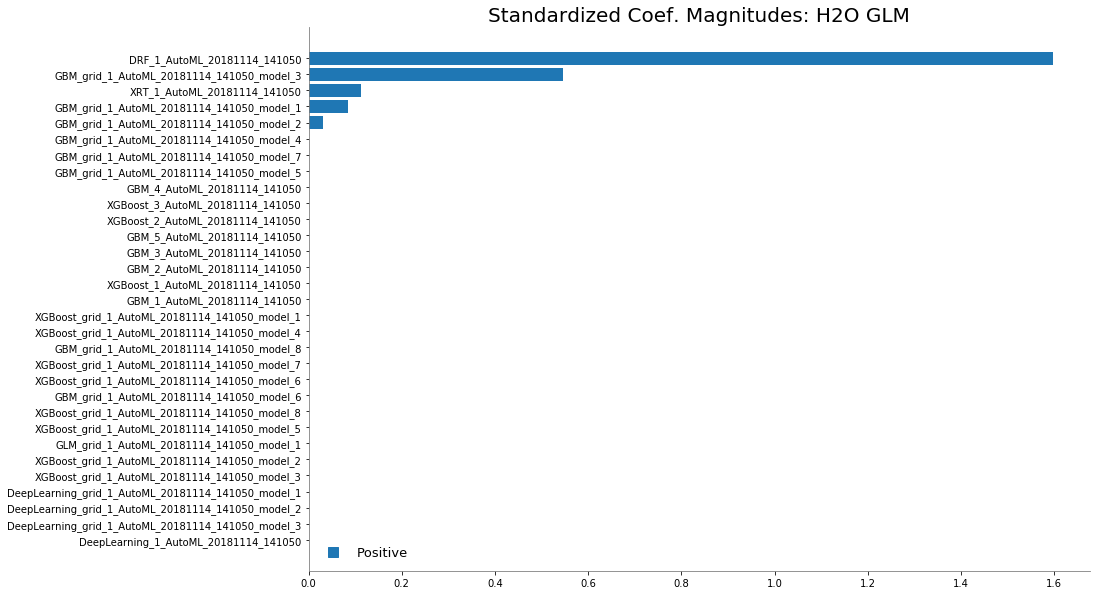

In [41]:
%matplotlib inline
metalearner.std_coef_plot()

In [42]:
h2o.save_model(aml.leader, path = "./product_model_bin")

'/home/siemanalyst/notebooks/siem/product_model_bin/StackedEnsemble_AllModels_AutoML_20181114_141050'

In [44]:
aml.leader.download_mojo(path = "./product_model_bin/pojo")

'/home/siemanalyst/notebooks/siem/product_model_bin/pojo'